# COVID-19 Tests result prediction with a Catboost classifier

In this project we apply a [Catboost](https://catboost.ai/) classifier to try to predict the results of COVID-19 tests from clinical medical studies data. We will try to understand a bit more about how these clinical variabes influence the probability of having a positive result in a COVID-19 test result.


In [141]:
!jupyter nbextension enable --py widgetsnbextension

from catboost import CatBoostClassifier, Pool, cv
#from dataprep.eda import plot
from matplotlib import pyplot as plt
from numpy.random import RandomState
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import catboost
import hyperopt
import json
import numpy as np
import pandas as pd
import seaborn as sns
import shap 



print(catboost.__version__)
#print(dataprep.__version__)
print(shap.__version__)

!python --version

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
0.23.2
0.35.0
Python 3.6.7


## Pre-processing and EDA

We are going to work over [patient data collected in the Hospital Isrealita Albert Einstein in São Paulo, Brazil](https://www.kaggle.com/einsteindata4u/covid19#dataset.xlsx)

This dataset contains anonimous data from patients that were tested with _SARS-CoV-2 RT-PCR_ and other aditional laboratory tests, done during their visit to the hospital. 

In [4]:
data_path = '../data/brasil_einstein_covid_tests.xlsx'
raw_data_einstein = pd.read_excel(data_path)
print(raw_data_einstein.shape)
raw_data_einstein.head()

(5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The full version of this dataset have ~5600 examples and ~111 variables.

To move forward properly, we will need to filter-out some input variables like the `Patient ID` and some others that produced errors when processing.

In [5]:

# Columns to explicitely drop
vars_to_drop = [
  'Patient ID',
  'Relationship (Patient/Normal)',
  'International normalized ratio (INR)',
  'Urine - pH',
]


# Variables related to type of admission that won't be used in a first approach
admition_vars = [
  'Patient addmited to regular ward (1=yes, 0=no)',
  'Patient addmited to semi-intensive unit (1=yes, 0=no)',
  'Patient addmited to intensive care unit (1=yes, 0=no)'
]

# Results of others tests
other_tests_vars = [
  # just the 25% of the dataset have values for these
  'Respiratory Syncytial Virus',
  'Influenza A',
  'Influenza B',
  'Parainfluenza 1',
  'CoronavirusNL63',
  'Rhinovirus/Enterovirus',
  'Coronavirus HKU1',
  'Parainfluenza 3',
  'Chlamydophila pneumoniae',
  'Adenovirus',
  'Parainfluenza 4',
  'Coronavirus229E',
  'CoronavirusOC43',
  'Inf A H1N1 2009',
  'Bordetella pertussis',
  'Metapneumovirus',
  'Parainfluenza 2',
  # just the 15% of the dataset have values for these
  'Influenza B, rapid test',
  'Influenza A, rapid test',

]

# name of the column that holds the results of the test
target_variable = 'SARS-Cov-2 exam result'

# list to variables to work with, dropping what we don't want from the total columns of the raw dataset
vars_to_work = list(set(raw_data_einstein.columns) - set(vars_to_drop) - set(admition_vars))
working_data = raw_data_einstein[vars_to_work]

print(f'New dataset sie:{working_data.shape}')


New dataset sie:(5644, 104)


In [146]:
working_data.dropna(how='all').shape#[target_variable].value_counts()

(1283, 97)

The first step to get a cleaner dataset is to drop the columns that have `Nulls` in all the examples.

In [6]:
# get the number of exampeles with null values by column
def get_null_counts(df):
  null_columns=df.columns[df.isnull().any()]
  nan_count_df = pd.DataFrame(data=df[null_columns].isnull().sum(),columns=['NaN count'])
  nan_count_df.sort_values('NaN count',ascending=False,inplace=True)
  return nan_count_df


null_count = get_null_counts(working_data)

print('\nAmount of rows with Null values by column')
print(null_count.to_string())


Amount of rows with Null values by column
                                                  NaN count
Urine - Sugar                                          5644
D-Dimer                                                5644
Partial thromboplastin time (PTT)                      5644
Mycoplasma pneumoniae                                  5644
Prothrombin time (PT), Activity                        5644
Fio2 (venous blood gas analysis)                       5643
Urine - Nitrite                                        5643
Vitamin B12                                            5641
Lipase dosage                                          5636
Albumin                                                5631
Arteiral Fio2                                          5624
Phosphor                                               5624
Ferritin                                               5621
Hb saturation (arterial blood gases)                   5617
Arterial Lactic Acid                                   56

In [7]:
nrows_limit = working_data.shape[0]

cols_empty = null_count.loc[null_count['NaN count'] >= nrows_limit].index.values
print('More columns to drop :\n{}'.format(cols_empty))

vars_to_work = list(set(working_data.columns) - set(cols_empty))

working_data = working_data[vars_to_work]
print(working_data.shape)
print(working_data.columns)
working_data.head(3)

More columns to drop :
['Urine - Sugar' 'D-Dimer' 'Partial thromboplastin time\xa0(PTT)\xa0'
 'Mycoplasma pneumoniae' 'Prothrombin time (PT), Activity']
(5644, 99)
Index(['Mean platelet volume ', 'Urine - Granular cylinders',
       'Total CO2 (venous blood gas analysis)',
       'Mean corpuscular volume (MCV)', 'Rods #', 'Indirect Bilirubin',
       'Gamma-glutamyltransferase ', 'Parainfluenza 4', 'Urine - Yeasts',
       'pH (venous blood gas analysis)', 'Albumin', 'Neutrophils',
       'Alkaline phosphatase', 'Coronavirus HKU1', 'Aspartate transaminase',
       'Phosphor', 'Segmented', 'Adenovirus', 'Urine - Red blood cells',
       'Respiratory Syncytial Virus', 'Lymphocytes', 'Arterial Lactic Acid',
       'Hb saturation (arterial blood gases)',
       'Mean corpuscular hemoglobin (MCH)', 'Parainfluenza 2',
       'Patient age quantile', 'Urine - Aspect', 'Urine - Urobilinogen',
       'CoronavirusNL63', 'Mean corpuscular hemoglobin concentration (MCHC)',
       'pCO2 (venous bloo

,Mean platelet volume,Urine - Granular cylinders,Total CO2 (venous blood gas analysis),Mean corpuscular volume (MCV),Rods #,Indirect Bilirubin,Gamma-glutamyltransferase,Parainfluenza 4,Urine - Yeasts,pH (venous blood gas analysis),...,Fio2 (venous blood gas analysis),Promyelocytes,CoronavirusOC43,Myeloblasts,Chlamydophila pneumoniae,Basophils,Red blood cell distribution width (RDW),HCO3 (arterial blood gas analysis),Inf A H1N1 2009,ctO2 (arterial blood gas analysis)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.010677,NaN,NaN,0.166192,NaN,NaN,NaN,not_detected,NaN,NaN,...,NaN,NaN,not_detected,NaN,not_detected,-0.223767,-0.625073,NaN,not_detected,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next we build a numerica variable named `y` that will be `1` for the `postive` exmaples and `0` for the `negative` ones.

In [9]:
working_data['y'] = 0
working_data.loc[working_data[target_variable]=='positive',['y']] = 1

print(working_data.loc[working_data.y == 1][[target_variable,'y']].sample(3))
print(working_data.loc[working_data.y == 0][[target_variable,'y']].sample(3))


     SARS-Cov-2 exam result  y
3569               positive  1
5092               positive  1
5118               positive  1
     SARS-Cov-2 exam result  y
3391               negative  0
1021               negative  0
3722               negative  0


We are going to inspect the class balance by counting the total of examples by unique value of the target column.

In [10]:
print(working_data['y'].value_counts())
print(working_data.shape)

0    5086
1     558
Name: y, dtype: int64
(5644, 100)


As expected, the number of examples with  `positive` result is less than the number of `negative` examples. 

We will treat the imbalance to get better results by taking a smaller number of `negative` examples trying to have a almost the same number of examples for this class as for the `positive` one. 

In [11]:
#col = target_variable
col = 'y'

# this value parametrizes how much % more of negatives we have from the positive count
sample_weight = 1.30

print(f'Classes proportions before sub-sample')
print(working_data[col].value_counts())

# split the dataset in positive and negative cases
working_data_pos = working_data.loc[working_data[col] == 1]
working_data_neg = working_data.loc[working_data[col] == 0]

# build a new one with only a sample of the negative cases, considering the weight we set before
working_data = pd.concat([
  working_data_pos,
  working_data_neg.sample(int(working_data_pos.shape[0] * sample_weight),random_state=123)
])

print(f'Umbalance after sub-sample')
print(working_data[col].value_counts())


Classes proportions before sub-sample
0    5086
1     558
Name: y, dtype: int64
Umbalance after sub-sample
0    725
1    558
Name: y, dtype: int64


Given that we sub-sampled the dataset, we should repeat the process to drop columns with all examples with null values. 

In [12]:
print(working_data.shape)
null_count = get_null_counts(working_data)
nrows_limit = working_data.shape[0]

cols_empty = null_count.loc[null_count['NaN count'] >= nrows_limit].index.values
print('More columns to drop :\n{}'.format(cols_empty))

# armamos una lista con las columnas que quedaran: el total menos las que tienen todas las filas en nulo
vars_to_work = list(set(working_data.columns) - set(cols_empty))

# obtenemos solo las columnas de interés
working_data = working_data[vars_to_work]
print(working_data.shape)
print(working_data.columns)
working_data.head(3)

(1283, 100)
More columns to drop :
['Urine - Nitrite' 'Fio2 (venous blood gas analysis)' 'Vitamin B12']
(1283, 97)
Index(['Mean platelet volume ', 'Urine - Granular cylinders',
       'Total CO2 (venous blood gas analysis)',
       'Mean corpuscular volume (MCV)', 'Rods #', 'Indirect Bilirubin',
       'Gamma-glutamyltransferase ', 'Parainfluenza 4', 'Urine - Yeasts',
       'pH (venous blood gas analysis)', 'Albumin', 'Neutrophils',
       'Coronavirus HKU1', 'Alkaline phosphatase', 'Aspartate transaminase',
       'Phosphor', 'Segmented', 'Adenovirus', 'Urine - Red blood cells',
       'Respiratory Syncytial Virus', 'Lymphocytes', 'Arterial Lactic Acid',
       'Hb saturation (arterial blood gases)',
       'Mean corpuscular hemoglobin (MCH)', 'Parainfluenza 2',
       'Patient age quantile', 'Urine - Aspect', 'Urine - Urobilinogen',
       'CoronavirusNL63', 'Mean corpuscular hemoglobin concentration (MCHC)',
       'pCO2 (venous blood gas analysis)', 'Lactic Dehydrogenase',
       

,Mean platelet volume,Urine - Granular cylinders,Total CO2 (venous blood gas analysis),Mean corpuscular volume (MCV),Rods #,Indirect Bilirubin,Gamma-glutamyltransferase,Parainfluenza 4,Urine - Yeasts,pH (venous blood gas analysis),...,Base excess (venous blood gas analysis),Promyelocytes,CoronavirusOC43,Myeloblasts,Chlamydophila pneumoniae,Basophils,Red blood cell distribution width (RDW),HCO3 (arterial blood gas analysis),Inf A H1N1 2009,ctO2 (arterial blood gas analysis)
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,NaN,NaN,...,NaN,NaN,not_detected,NaN,not_detected,NaN,NaN,NaN,not_detected,NaN
513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,NaN,NaN,...,NaN,NaN,not_detected,NaN,not_detected,NaN,NaN,NaN,not_detected,NaN


## Modeling
To start the modeling phase we split the dataset to have the inputs and the ouputs in different variables.

In [15]:
X = working_data.drop(target_variable, axis=1)
X = X.drop('y', axis=1)
y = working_data['y']
#y = working_data[target_variable]

print(f'Input (X) shape : {X.shape}')
print(f'Output (y) shape : {y.shape}')

Input (X) shape : (1283, 95)
Output (y) shape : (1283,)


Because this dataset have a lot of missing values, we need to treat them in some way. [It is expected that if we set a value extremely different from the common in each column for the `Null` examples, the classification method used here will consider them as missing and work with them properly](https://render.githubusercontent.com/view/ipynb?commit=25c7f813184604d1b5d1d118fc82e001add6cf30&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f636174626f6f73742f7475746f7269616c732f323563376638313331383436303464316235643164313138666338326530303161646436636633302f707974686f6e5f7475746f7269616c2e6970796e62&nwo=catboost%2Ftutorials&path=python_tutorial.ipynb&repository_id=138584767&repository_type=Repository#1.3-Feature-Preparation). In this case we will use `-999` to fill the `NaN`s

In [17]:
X = X.fillna(-999)
X.sample(3)

,Mean platelet volume,Urine - Granular cylinders,Total CO2 (venous blood gas analysis),Mean corpuscular volume (MCV),Rods #,Indirect Bilirubin,Gamma-glutamyltransferase,Parainfluenza 4,Urine - Yeasts,pH (venous blood gas analysis),...,Base excess (venous blood gas analysis),Promyelocytes,CoronavirusOC43,Myeloblasts,Chlamydophila pneumoniae,Basophils,Red blood cell distribution width (RDW),HCO3 (arterial blood gas analysis),Inf A H1N1 2009,ctO2 (arterial blood gas analysis)
2419,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,not_detected,-999,-999.0,...,-999.0,-999.0,not_detected,-999.0,not_detected,-999.0,-999.0,-999.0,not_detected,-999.0
3257,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,...,-999.0,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999,-999.0
1340,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,...,-999.0,-999.0,-999,-999.0,-999,-999.0,-999.0,-999.0,-999,-999.0


The main benefit of the _Catboost_ technique is that is better than other in dealing with categorical variables. That is why we need to indicate which of the columns are categorical to indicate it to the classifier. 

In [18]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices = list(set(categorical_features_indices))
print(f'Categorical columns: \n{X.columns[categorical_features_indices]}')

Categorical columns: 
Index(['Urine - Granular cylinders', 'Parainfluenza 4', 'Urine - Yeasts',
       'Coronavirus HKU1', 'Adenovirus', 'Respiratory Syncytial Virus',
       'Parainfluenza 2', 'Patient age quantile', 'Urine - Aspect',
       'Urine - Urobilinogen', 'CoronavirusNL63', 'Influenza B',
       'Urine - Ketone Bodies', 'Metapneumovirus', 'Urine - Leukocytes',
       'Urine - Protein', 'Parainfluenza 3', 'Urine - Hyaline cylinders',
       'Urine - Esterase', 'Rhinovirus/Enterovirus', 'Urine - Bile pigments',
       'Influenza A, rapid test', 'Urine - Color', 'Influenza A', 'Strepto A',
       'Bordetella pertussis', 'Urine - Crystals', 'Parainfluenza 1',
       'Urine - Hemoglobin', 'Coronavirus229E', 'Influenza B, rapid test',
       'CoronavirusOC43', 'Chlamydophila pneumoniae', 'Inf A H1N1 2009'],
      dtype='object')


Next we split the dataset into three disjoint _train_ , _validation_ and _test_ sets:
* `train-set`: `80%` of the full dataset used to train
* `validation-set` : `10%` of the total, used to choose the best hyper parameter configuration
* `test-set` : `10%` from the total dataset, used to evaluate how good the model is to predict brand new cases


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size = 0.1)
print(X_train.shape)
X_train.head(3)

(1038, 95)


,Mean platelet volume,Urine - Granular cylinders,Total CO2 (venous blood gas analysis),Mean corpuscular volume (MCV),Rods #,Indirect Bilirubin,Gamma-glutamyltransferase,Parainfluenza 4,Urine - Yeasts,pH (venous blood gas analysis),...,Base excess (venous blood gas analysis),Promyelocytes,CoronavirusOC43,Myeloblasts,Chlamydophila pneumoniae,Basophils,Red blood cell distribution width (RDW),HCO3 (arterial blood gas analysis),Inf A H1N1 2009,ctO2 (arterial blood gas analysis)
4924,-0.662483,-999,-999.0,-0.63499,-999.0,-999.0,-999.0,not_detected,-999,-999.0,...,-999.0,-999.0,not_detected,-999.0,not_detected,-0.223767,-1.067355,-999.0,not_detected,-999.0
1644,-999.000000,-999,-999.0,-999.00000,-999.0,-999.0,-999.0,-999,-999,-999.0,...,-999.0,-999.0,-999,-999.0,-999,-999.000000,-999.000000,-999.0,-999,-999.0
120,-999.000000,-999,-999.0,-999.00000,-999.0,-999.0,-999.0,-999,-999,-999.0,...,-999.0,-999.0,-999,-999.0,-999,-999.000000,-999.000000,-999.0,-999,-999.0


Next we will train the actual classifier and do some hyper-parameter optimization to try different configurations for the classifier.

In [42]:
# which metric do we want to optimize? 
#metric = 'Precision' 
metric = 'Recall'
#metric = 'F1'
#metric = 'BalancedAccuracy'

def hyperopt_objective(params):
    
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=float(params['learning_rate']),
        max_depth=int(params['max_depth']),
        subsample=float(params['subsample']),
        colsample_bylevel=float(params['colsample_bylevel']),
        bootstrap_type = 'Bernoulli',
        iterations=500,
        eval_metric=metric,
        random_seed=123,
        verbose=False,
        loss_function='CrossEntropy',
        use_best_model = True,
        #task_type='GPU',
        task_type='CPU',
        early_stopping_rounds=100,
    )
    
    cv_data = cv(
        Pool(X_validation, y_validation, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_metric = np.max(cv_data[f'test-{metric}-mean'])
    
    return 1 - best_metric # as hyperopt minimises

In [43]:

# the parameters to choose are sampled with uniform destribution between the ranges specified
params_space = {
    'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg',2,5),
    'learning_rate': hyperopt.hp.uniform('learning_rate',0.001,0.01),
    'max_depth' : hyperopt.hp.uniform('max_depth',4,8),
    'subsample' : hyperopt.hp.uniform('subsample',0.8,1.0),
    'colsample_bylevel' : hyperopt.hp.uniform('colsample_bylevel',0.7,0.9)
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=5,
    trials=trials,
    rstate=RandomState(123)
)

with open(f'../models/best_{metric}.json', 'w') as fp:
    json.dump(best, fp)
    
print(best)

Stopped by overfitting detector  (100 iterations wait)

Stopped by overfitting detector  (100 iterations wait)

Stopped by overfitting detector  (100 iterations wait)

Stopped by overfitting detector  (100 iterations wait)

Stopped by overfitting detector  (100 iterations wait)

100%|██████████| 5/5 [00:28<00:00,  5.66s/trial, best loss: 0.8110661268556005]
{'colsample_bylevel': 0.8732175646075014, 'l2_leaf_reg': 4.098767964916441, 'learning_rate': 0.003134356934526143, 'max_depth': 6.3617649046056455, 'subsample': 0.945606018250915}


In [44]:

params = {
    'iterations': 500,
    'eval_metric': metric,
    'random_seed' : 123,
    'use_best_model': True,
    'loss_function': 'CrossEntropy',
    #'task_type':'GPU',
    'task_type':'CPU',
    'early_stopping_rounds' : 100,
    'bootstrap_type' : 'Bernoulli',
    'verbose' : True,
    'learning_rate': float(best['learning_rate']),
    'l2_leaf_reg' : float(best['l2_leaf_reg']),
    'max_depth' : int(best['max_depth']),
    'subsample' : float(best['subsample']),
    'colsample_bylevel' : float(best['colsample_bylevel']),
    #'class_weights' : train_class_weights
}

model = CatBoostClassifier(**params)

print(model)

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',  # you can uncomment this for text output
    #verbose=True,
    plot=True
)

model.save_model(f'../models/catboost_model_{metric}.bin')
model.save_model(f'../models/catboost_model_{metric}.json', format='json')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7270742	test: 0.6888889	best: 0.6888889 (0)	total: 52.3ms	remaining: 26.1s
1:	learn: 0.6834061	test: 0.7555556	best: 0.7555556 (1)	total: 92.4ms	remaining: 23s
2:	learn: 0.1135371	test: 0.1555556	best: 0.7555556 (1)	total: 112ms	remaining: 18.6s
3:	learn: 0.1113537	test: 0.1555556	best: 0.7555556 (1)	total: 137ms	remaining: 17s
4:	learn: 0.1091703	test: 0.1555556	best: 0.7555556 (1)	total: 167ms	remaining: 16.5s
5:	learn: 0.1069869	test: 0.1555556	best: 0.7555556 (1)	total: 215ms	remaining: 17.7s
6:	learn: 0.1069869	test: 0.1555556	best: 0.7555556 (1)	total: 268ms	remaining: 18.9s
7:	learn: 0.0982533	test: 0.1333333	best: 0.7555556 (1)	total: 315ms	remaining: 19.4s
8:	learn: 0.0982533	test: 0.1333333	best: 0.7555556 (1)	total: 353ms	remaining: 19.3s
9:	learn: 0.0917031	test: 0.1333333	best: 0.7555556 (1)	total: 436ms	remaining: 21.4s
10:	learn: 0.0982533	test: 0.1555556	best: 0.7555556 (1)	total: 497ms	remaining: 22.1s
11:	learn: 0.0982533	test: 0.1555556	best: 0.7555556 (1

Now we evaluate the model over the trainset and test set as well.

In [34]:
'''
  Function to plot and print a confusion matrix and common classification metrics
'''
def plot_cm(labels, predictions, p=0.5):

  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total : ', np.sum(cm[1]))



Using model with parameters : 
 {'use_best_model': True, 'rsm': 0.7983968081, 'bootstrap_type': 'Bernoulli', 'eval_metric': 'F1', 'od_wait': 100, 'verbose': 1, 'iterations': 500, 'logging_level': 'Verbose', 'loss_function': 'CrossEntropy', 'l2_leaf_reg': 2.071019562, 'task_type': 'CPU', 'subsample': 0.9985036215, 'depth': 7, 'learning_rate': 0.008527981224, 'random_seed': 123}
Train report
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       580
           1       0.97      0.12      0.22       458

    accuracy                           0.61      1038
   macro avg       0.78      0.56      0.48      1038
weighted avg       0.76      0.61      0.51      1038

Train Confusion matrix

True Negatives:  578
False Positives:  2
False Negatives:  402
True Positives:  56
Total :  458


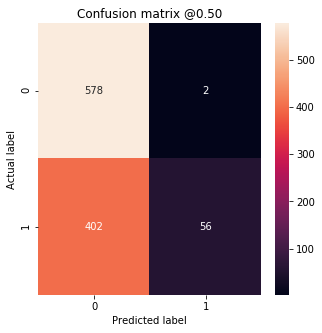

Test report
              precision    recall  f1-score   support

           0       0.61      0.99      0.75        74
           1       0.89      0.15      0.25        55

    accuracy                           0.63       129
   macro avg       0.75      0.57      0.50       129
weighted avg       0.73      0.63      0.54       129

Test Confusion matrix

True Negatives:  73
False Positives:  1
False Negatives:  47
True Positives:  8
Total :  55


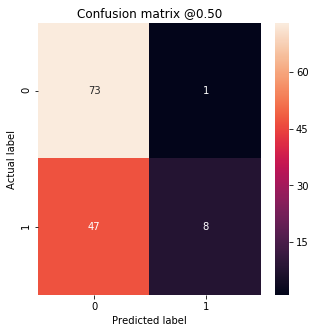

In [51]:

metric = 'F1'
best_model = CatBoostClassifier()
best_model.load_model(f'../models/catboost_model_{metric}.bin')
print(f'Using model with parameters : \n {best_model.get_params()}')

train_predictions = best_model.predict(X_train)

print('Train report')
print(classification_report(y_train, train_predictions))

print('Train Confusion matrix')
print()
plot_cm(y_train, train_predictions)
plt.show()



test_predictions = best_model.predict(X_test)

print('Test report')
print(classification_report(y_test, test_predictions))

print('Test Confusion matrix')
print()
plot_cm(y_test, test_predictions)
plt.show()


Depending on what metric we decided to optimize is what we get from the model. In this case we decided to optimize F1 and we have a decent _Test Precision_ (90%) even though we still see a bit of possible overfitting if we look at the difference with _Train Precision_.

Also, it is possible to see that the recall is really low so if we use this model, we could be missing the 90% of potential cases. 


## Understanding the predictions

Now that we have a baseline model we try to see how it could behave in the real-life analizing some predictions over the testset.

We can see which are the most important variables and how they behave by test result

In [70]:
feature_importances = model.get_feature_importance(prettified=True)
important_features = feature_importances.loc[feature_importances['Importances'] > 0.0]
important_features

,Feature Id,Importances
0,Patient age quantile,49.560447
1,Eosinophils,17.184441
2,Leukocytes,11.723247
3,Direct Bilirubin,8.242988
4,Lactic Dehydrogenase,5.008295
5,Monocytes,3.235406
6,Coronavirus HKU1,1.393310
7,Mean corpuscular hemoglobin concentration (MCHC),1.362833
8,Chlamydophila pneumoniae,1.104754
9,"Influenza A, rapid test",0.938709


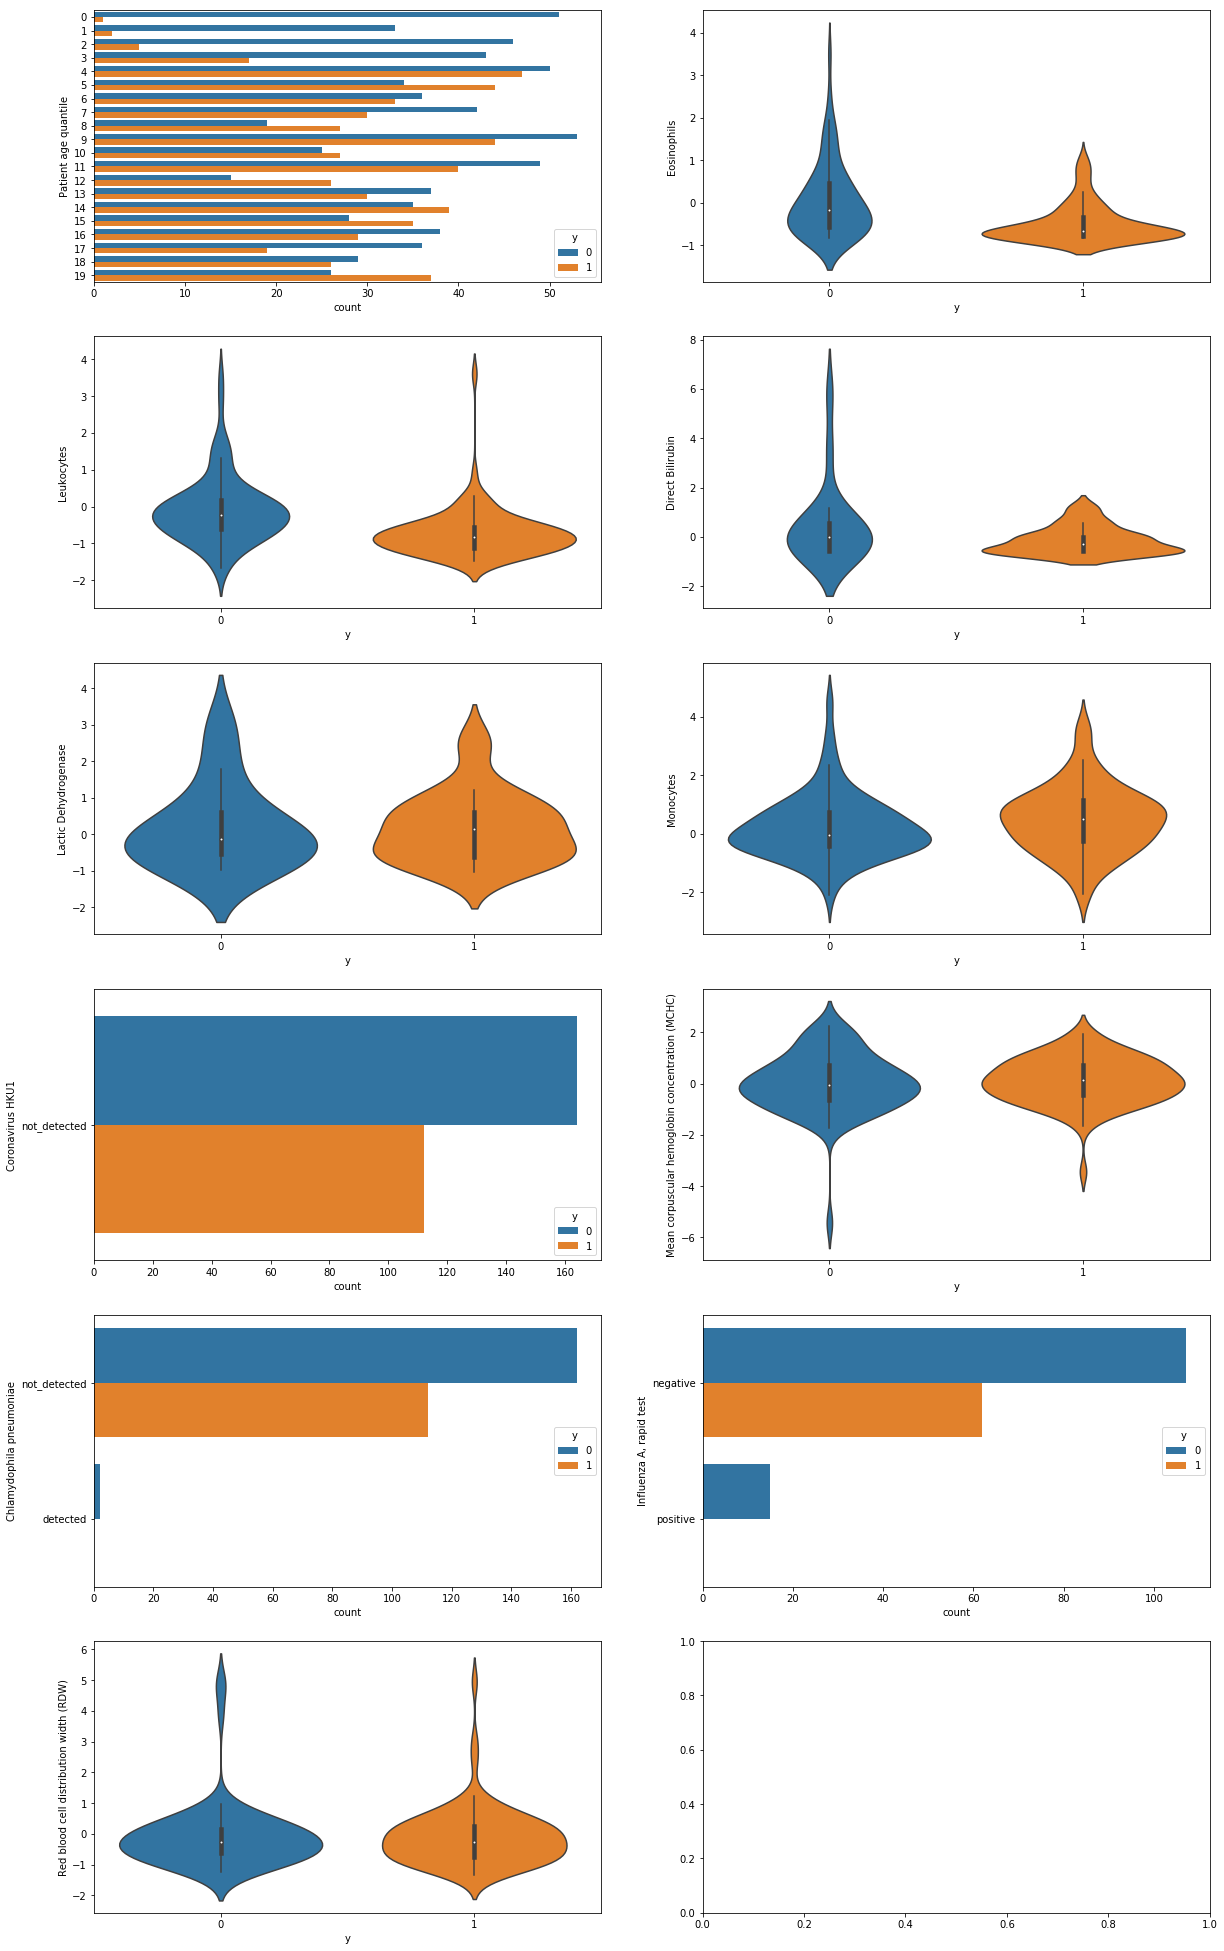

In [223]:

test_df = working_data

f,ax = plt.subplots(int((important_features.shape[0]+1)/2),2,figsize=(20,35))

row = 0
col = 0

for i in range(important_features.shape[0]):
    #print(f'{row}-{col}')
    
    the_ax = ax[row,col]

    if test_df[important_features['Feature Id'].values[i]].dtypes != np.float :
        sns.countplot(data=test_df,y=important_features['Feature Id'].values[i],hue='y', ax = the_ax)
    else:
        sns.violinplot(data=test_df,x='y',y=important_features['Feature Id'].values[i] , ax = the_ax)
        
    if col == 0 :
        col += 1
    else :
        row += 1
        col = 0

plt.show()
        



Let's first look at how it behaves with _true positive_ cases to analyze where the model is good.

Next we use the [SHAP](https://github.com/slundberg/shap) package to understand these _true positive_ predictions and see which are the most important variables for the model in this case and how they influence the prediction probability.

Using the `shap_values` we get a [`summary_plot`](https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot) where we see at the left the most important variables and each point corresponds to an example. Points located to the righ move the  prediction probability for the postive class to higher values. The color of the point shows the value that each of them had for the current variable.

(55, 95)
(8, 95)
-0.001708560512123208
(8, 95)


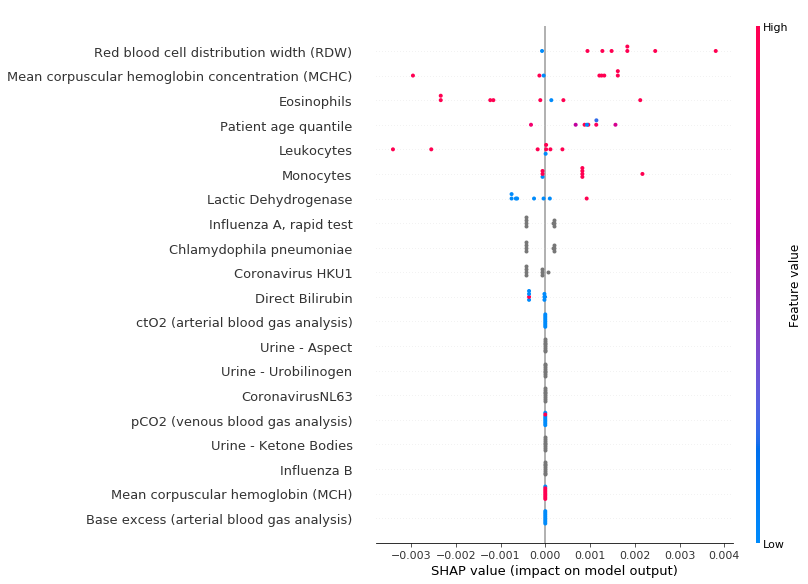

In [224]:
positive_cases_index = y_test.iloc[np.where(y_test == 1)].index

true_datapoints = X_test.loc[positive_cases_index]
print(true_datapoints.shape)

postive_datapoints_predictions = best_model.predict(true_datapoints)

true_positives_index = np.where(postive_datapoints_predictions == 1)[0]
true_positives_datapoints = true_datapoints.iloc[true_positives_index,:]
print(true_positives_datapoints.shape)

pool_tp = Pool(data=true_positives_datapoints, label=pd.Series(np.ones(true_positives_datapoints.shape[0])), cat_features=categorical_features_indices)
shap_values_tp = model.get_feature_importance(pool_tp, type='ShapValues')
expected_value = shap_values_tp[0,-1]
print(expected_value)
shap_values_tp = shap_values_tp[:,:-1]
print(shap_values_tp.shape)

shap.summary_plot(shap_values_tp, true_positives_datapoints)

We can see in detail with Force plots how each variable moves he prediction probability for the examples that predicted positive with higher score.

First we see the distribution of the probability scores for the positive class

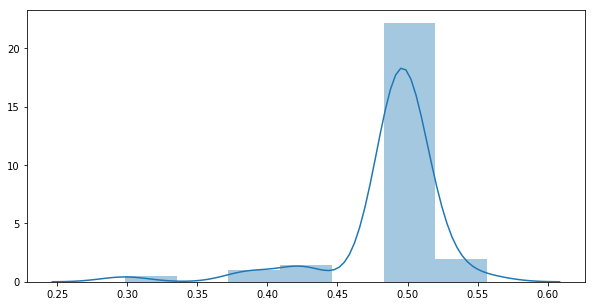

In [200]:
plt.figure(figsize=(10,5))
sns.distplot(best_model.predict_proba(true_datapoints)[:,1])

Most of our scores for the postive predictions are near 0.5 so we consider as "good" predictions those over ~0.5 

-0.001708560512123208
(4, 95)


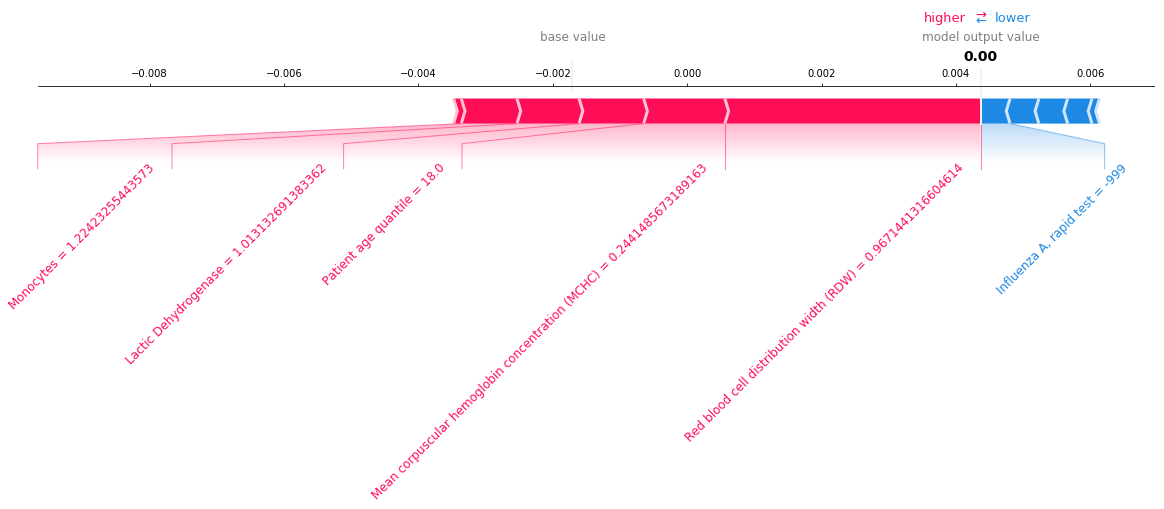

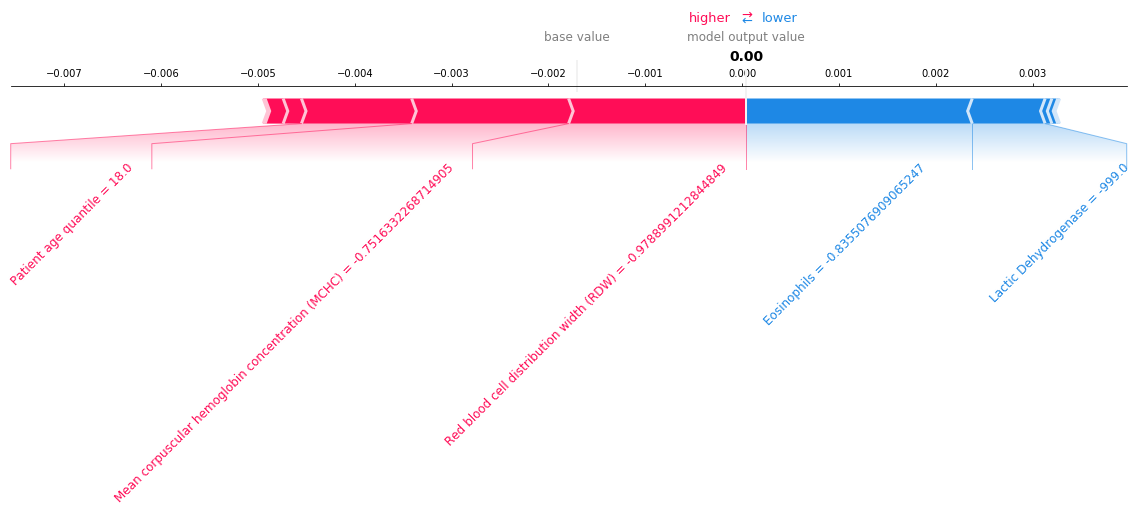

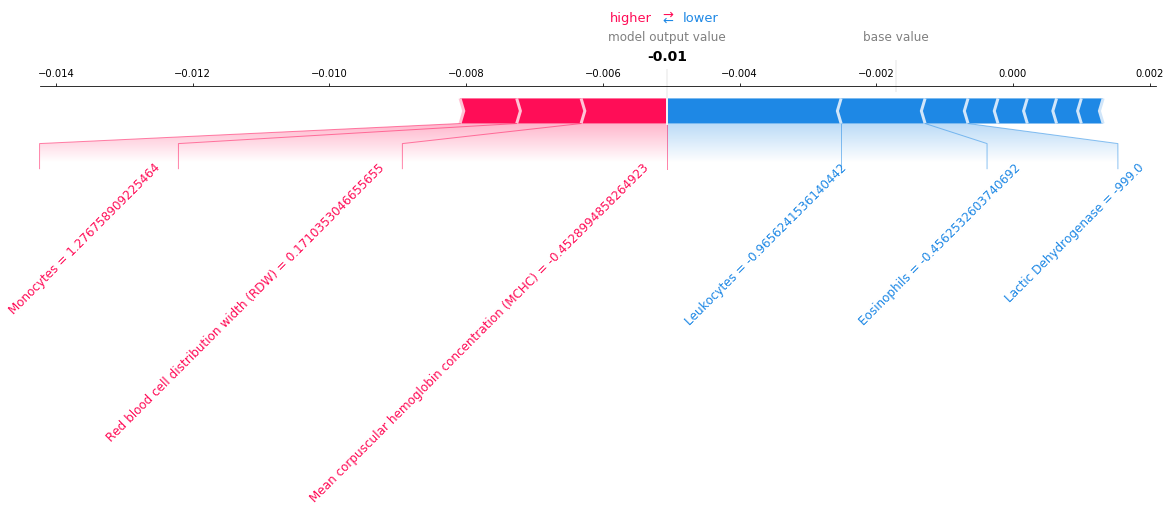

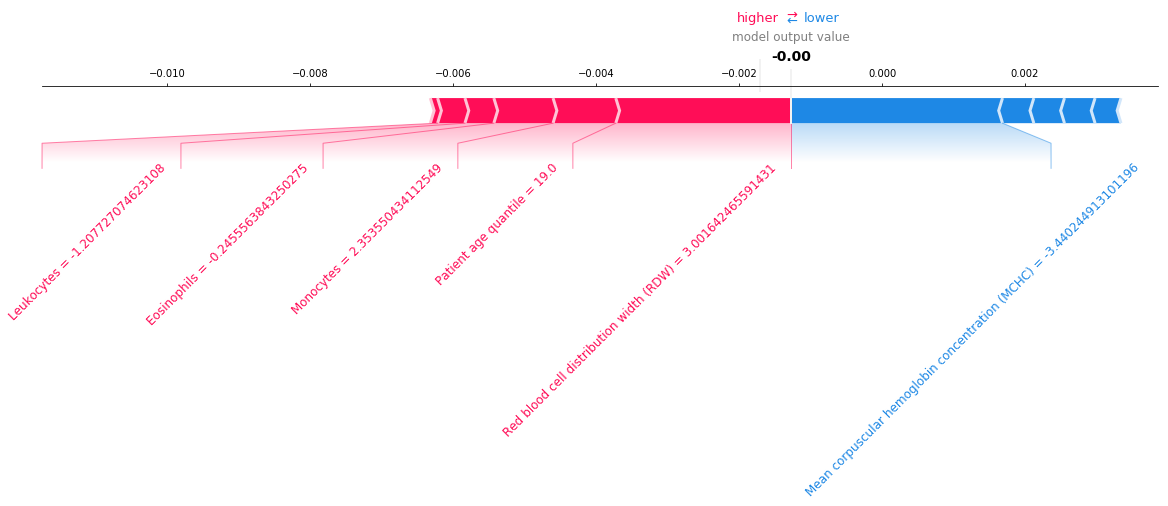

In [201]:
good_true_positives_index = np.where(best_model.predict_proba(true_datapoints)[:,1] >= 0.52)[0]
good_true_positives_datapoints = true_datapoints.iloc[good_true_positives_index,:]
pool_gtp = Pool(data=good_true_positives_datapoints, label=pd.Series(np.ones(good_true_positives_datapoints.shape[0])), cat_features=categorical_features_indices)
shap_values_gtp = model.get_feature_importance(pool_gtp, type='ShapValues')
expected_value = shap_values_gtp[0,-1]
print(expected_value)
shap_values_gtp = shap_values_gtp[:,:-1]
print(shap_values_gtp.shape)
for i in range(good_true_positives_datapoints.shape[0]):
    shap.force_plot(expected_value, shap_values_gtp[i,:], good_true_positives_datapoints.iloc[i,:],matplotlib=True,text_rotation=45)

Now we repeat the process for negative cases, focusing on the _true negatives_

(74, 95)
(39, 95)
-0.001708560512123208
(39, 95)


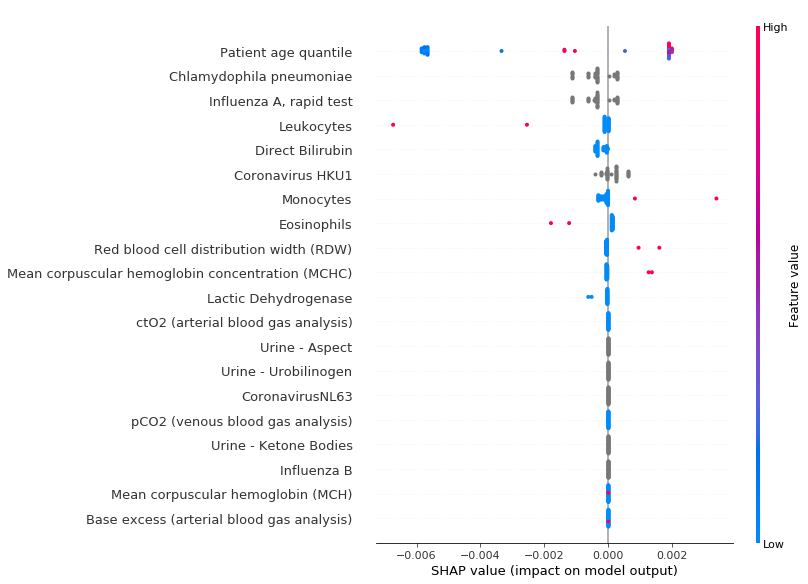

In [225]:
negative_cases_index = y_test.iloc[np.where(y_test == 0)].index
false_datapoints = X_test.loc[negative_cases_index]
print(false_datapoints.shape)

negative_datapoints_predictions = model.predict(false_datapoints)
true_negative_index = np.where(negative_datapoints_predictions == 0)[0]
true_negative_datapoints = false_datapoints.iloc[true_negative_index,:]
print(true_negative_datapoints.shape)

pool_tn = Pool(data=true_negative_datapoints, label=pd.Series(np.zeros(true_negative_datapoints.shape[0])), cat_features=categorical_features_indices)
shap_values_tn = model.get_feature_importance(pool_tn, type='ShapValues')
expected_value_tn = shap_values_tn[0,-1]
print(expected_value_tn)
shap_values_tn = shap_values_tn[:,:-1]
print(shap_values_tn.shape)

shap.summary_plot(shap_values_tn, true_negative_datapoints)

Again we will see the force plots for the "good" negative predictions, starting with the distribution of prediction scores for the negative class.

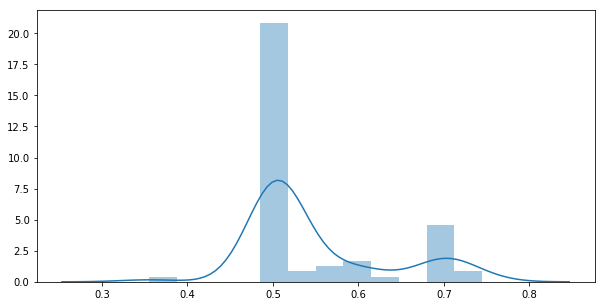

In [202]:
plt.figure(figsize=(10,5))
sns.distplot(best_model.predict_proba(false_datapoints)[:,0])

In this case we have several predictions with good scores having probabilities over 0.7 so we choose this value as thresshold

-0.001708560512123208
(9, 95)


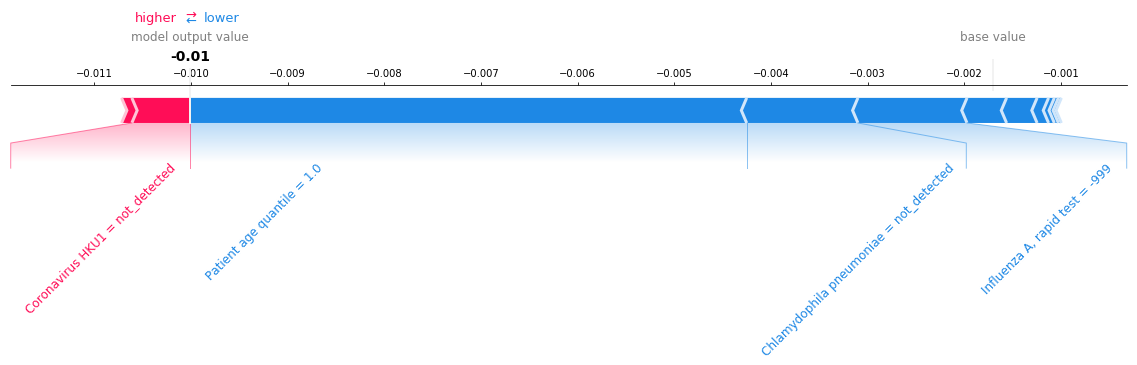

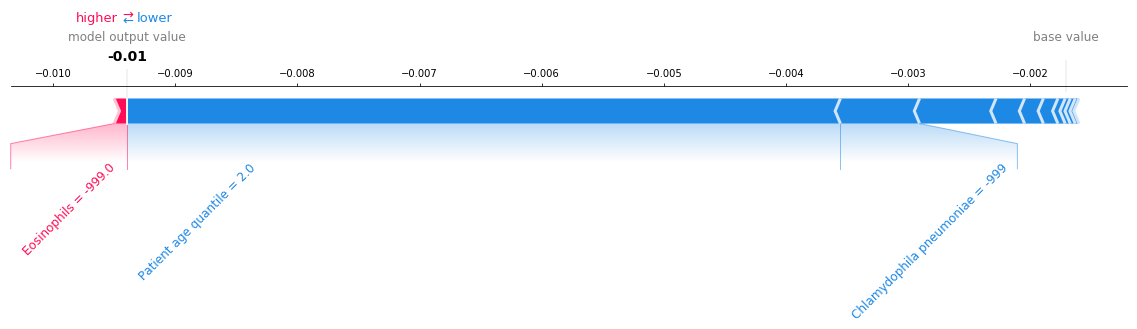

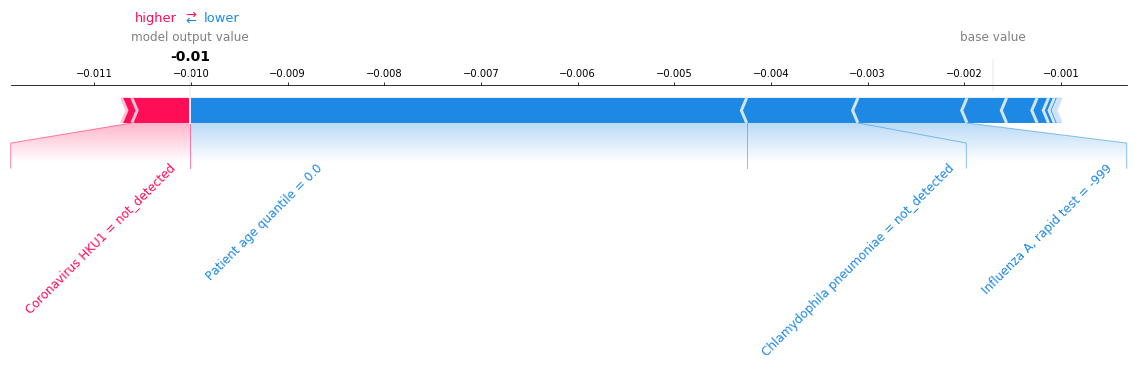

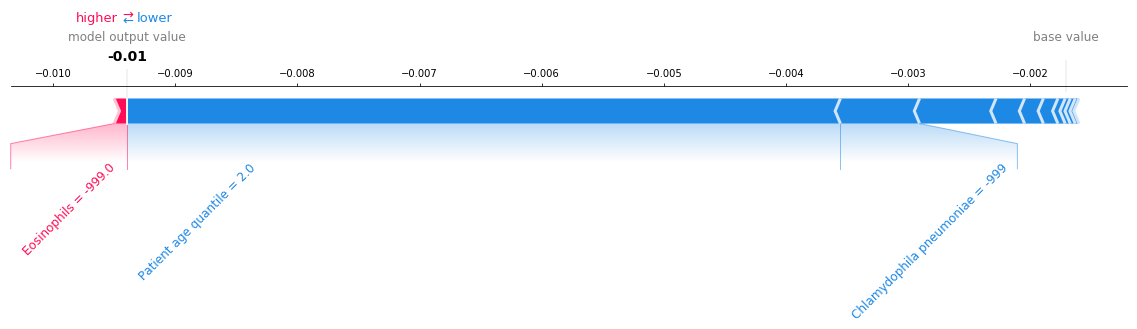

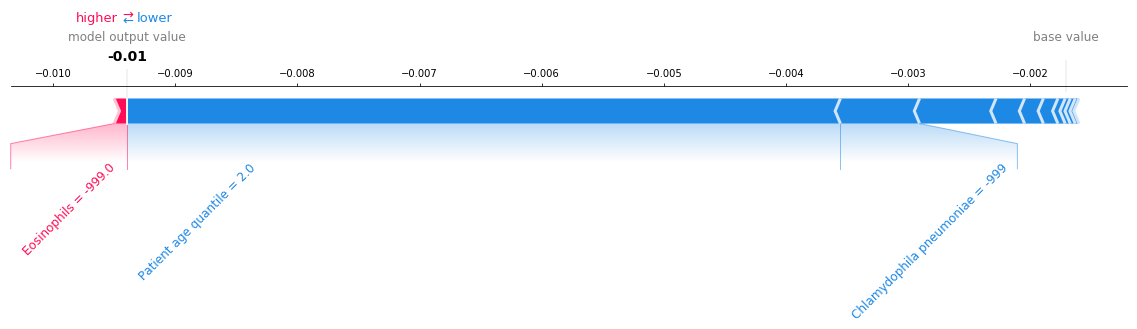

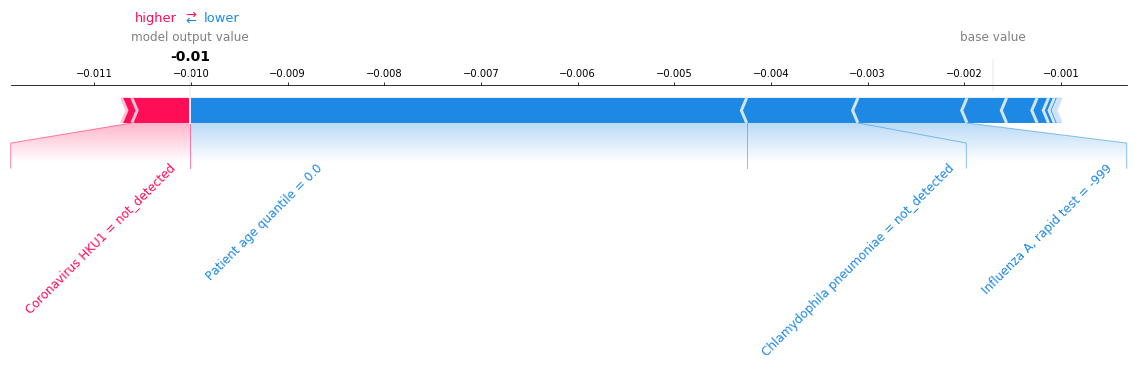

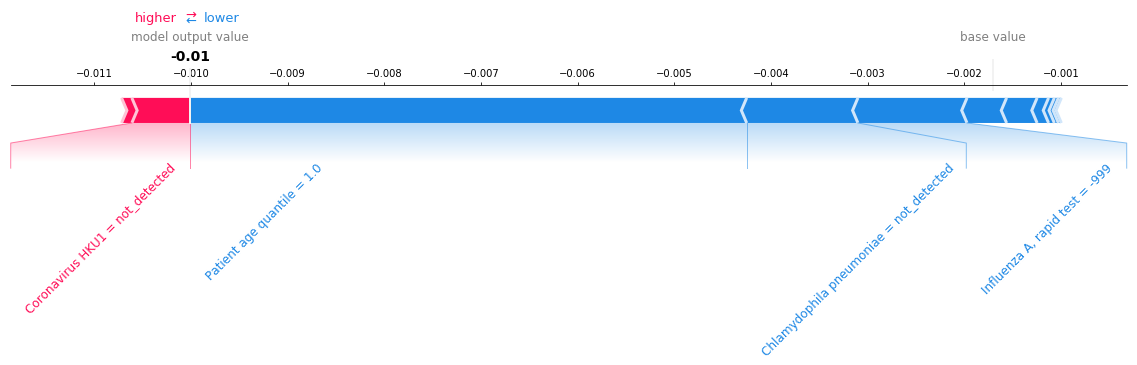

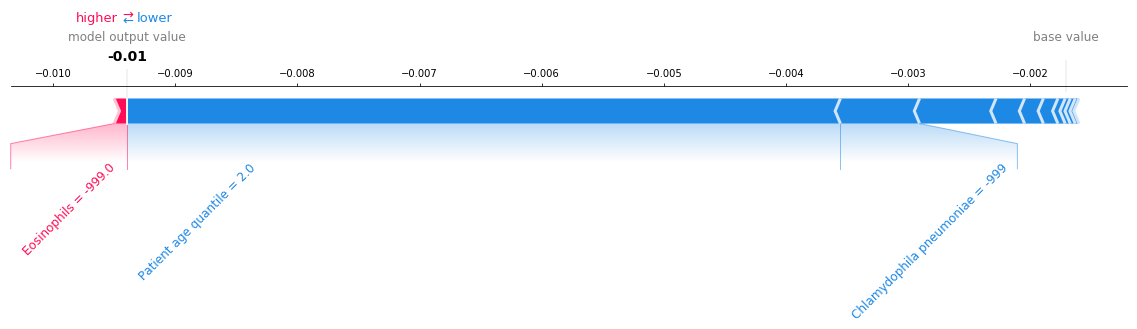

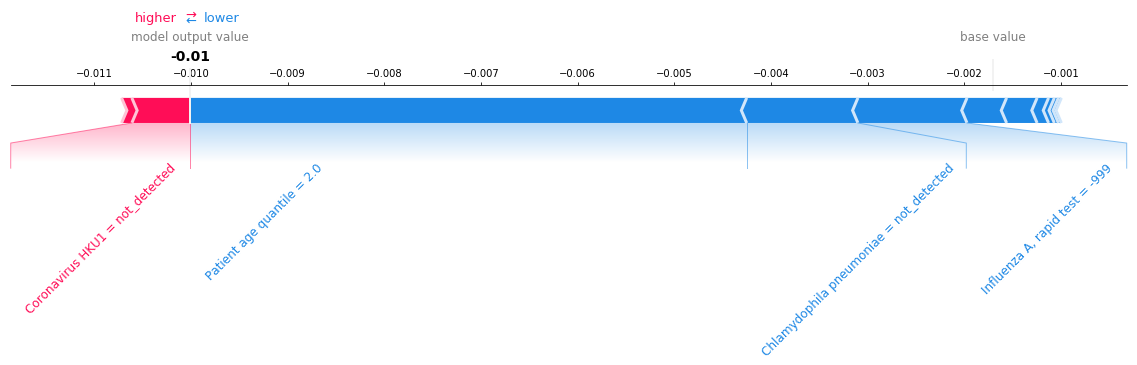

In [203]:
good_true_negatives_index = np.where(best_model.predict_proba(false_datapoints)[:,0] >= 0.70)[0]
good_true_negatives_datapoints = false_datapoints.iloc[good_true_negatives_index,:]
pool_gtn = Pool(data=good_true_negatives_datapoints, label=pd.Series(np.ones(good_true_negatives_datapoints.shape[0])), cat_features=categorical_features_indices)
shap_values_gtn = model.get_feature_importance(pool_gtn, type='ShapValues')
expected_value = shap_values_gtn[0,-1]
print(expected_value)
shap_values_gtn = shap_values_gtn[:,:-1]
print(shap_values_gtn.shape)
for i in range(good_true_negatives_datapoints.shape[0]):
    shap.force_plot(expected_value, shap_values_gtn[i,:], good_true_negatives_datapoints.iloc[i,:],matplotlib=True,text_rotation=45)